### Kaggle: Time Series Analysis: Store Sales Predictions

Date Updated: 08/03/2025

Data Link [Here](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data)


In [10]:
# imports 
import warnings

import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:,.0f}'.format)

### Ensuring the Package Loads

If you still encounter an import error after installing `pmdarima`:

- **Restart the kernel** so the new package is recognized.
- Verify the notebook’s Python interpreter matches the `pip` path:
  ```python
  import sys
  print(sys.executable)
  !which pip
  ```
- If they differ, install into the correct environment:
  ```python
  import sys
  !{sys.executable} -m pip install pmdarima
  ```

In [2]:
df_train = pd.read_csv("data/train.csv", parse_dates = ['date'])
df_test = pd.read_csv("data/test.csv", parse_dates=['date'])
df_oil = pd.read_csv("data/oil.csv")
df_holidays_events = pd.read_csv("data/holidays_events.csv")

In [3]:
print(f"{df_train.info()} \n")
print(f"{df_oil.info()} \n")
print(f"{df_holidays_events.info()} \n")


print(f"=== Training Dataframe === \n {df_train.head()}")
print(f"=== Oil Dataframe === \n {df_oil.head()}")
print(f"=== Holidays Dataframe === \n {df_holidays_events.head()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         

/var/folders/tm/zd2ldwcj6w5cml9j9n1_pcsr0000gn/T/ipykernel_986/88648140.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=(0, 0, 0.85, 1))


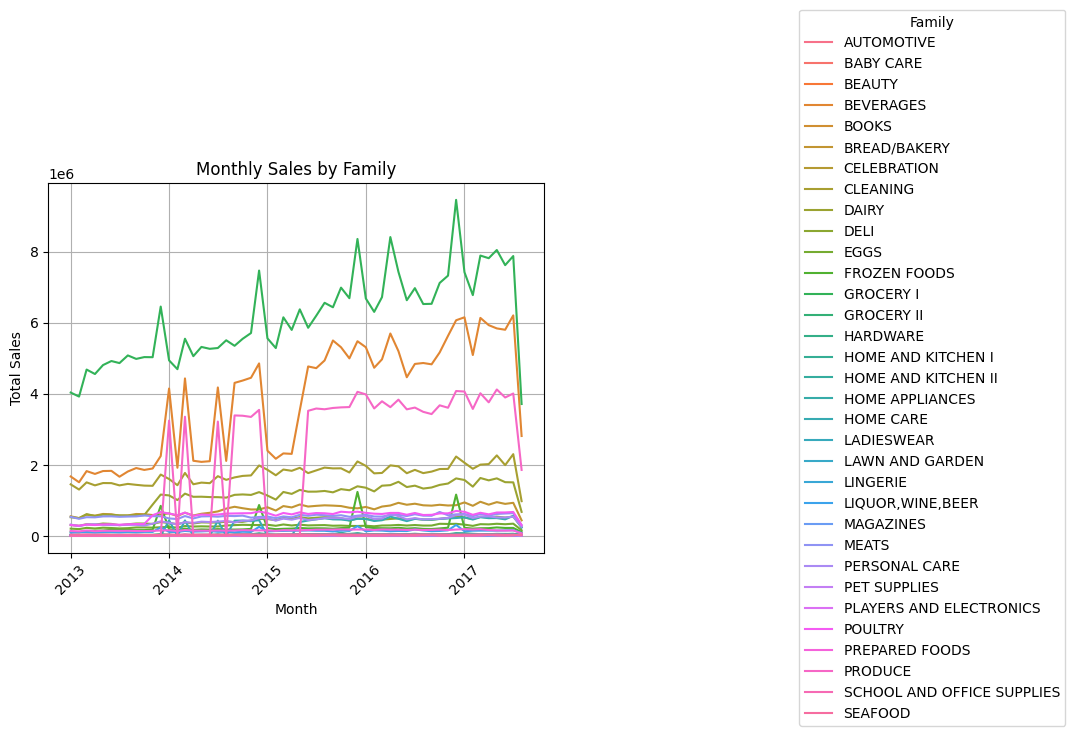

In [4]:
# Create Month Column 
df_train['year_month'] = df_train['date'].dt.to_period('M').dt.to_timestamp()

summary_sales = (
    df_train
    .groupby(["year_month", "family"])
    .agg(total_sales=("sales", "sum"))
    .reset_index()
)

sns.lineplot(
    data = summary_sales, 
    x = 'year_month', 
    y = 'total_sales',
    hue = 'family',
    linestyle = '-'
)

plt.title('Monthly Sales by Family')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(
    title='Family',
    loc='center left',            
    bbox_to_anchor=(1.5, 0.5)    
)

plt.tight_layout(rect=(0, 0, 0.85, 1))
plt.show()



## Modeling Approach (SARIMAX)

To build a robust sales forecasting model we will be implementing SARIMAX 

- **Time-Series Methods**: SARIMAX to include holiday and oil regressors


Notes: 

**Autoregression** (p: autoregressive)

Model's regression on its own lagged values. Using past data to predict future outcomes.


**Integrated** (d: differencing)

A stationary time series has a constant mean, variance, and covariance over time - making it easier to predict patterns. 

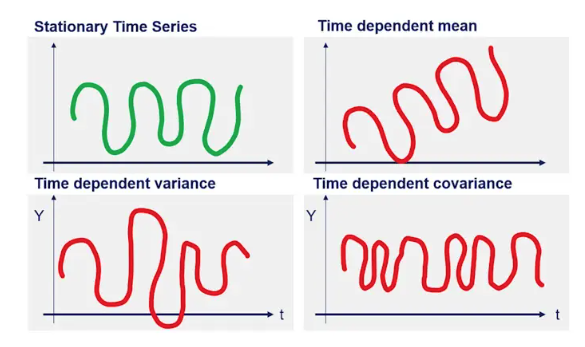

**Average** (q: Moving Average)

Moving 'average' - using past information to predict future outcomes. Autoregression uses past values of the time series and moving average uses the model's errors as information





In [5]:
df_train.head(1)

,id,date,store_nbr,family,sales,onpromotion,year_month
0,0,2013-01-01,1,AUTOMOTIVE,0,0,2013-01-01


In [6]:
# prediction of all sales through all stores and families 
top_lvl_df_train = df_train.groupby('date').agg(total_sales = ('sales', 'sum')).reset_index()

top_lvl_df_train['date'] = pd.to_datetime(top_lvl_df_train['date'])

print(top_lvl_df_train.head())

        date  total_sales
0 2013-01-01        2,512
1 2013-01-02      496,092
2 2013-01-03      361,461
3 2013-01-04      354,460
4 2013-01-05      477,350


Lower Bound for Outliers: -72139.50660627498

Upper Bound for Outliers: 1300796.475110125

Negative Sales: Empty DataFrame
Columns: [date, total_sales]
Index: []
           date  total_sales
1577 2017-05-01    1,306,699
1200 2016-04-18    1,345,921
1611 2017-06-04    1,376,512
1458 2017-01-02    1,402,306
1547 2017-04-01    1,463,084
== Checking New Year Sales == 
            date  total_sales
0    2013-01-01        2,512
364  2014-01-01        8,602
728  2015-01-01       12,774
1092 2016-01-01       16,433
1457 2017-01-01       12,083


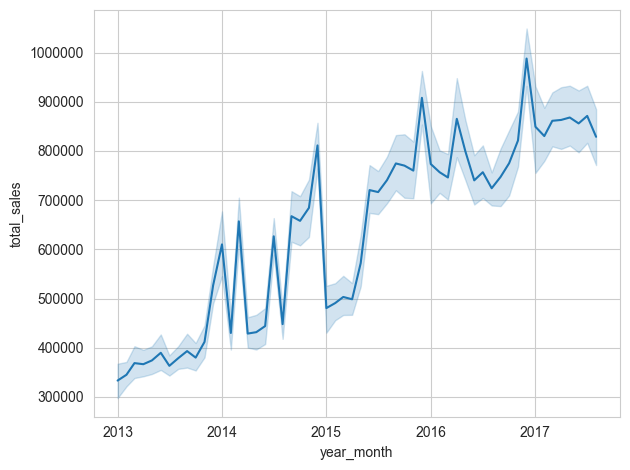

In [7]:
# find outliers 
Q1 = top_lvl_df_train['total_sales'].quantile(0.25) 
Q3 = top_lvl_df_train['total_sales'].quantile(0.75)

IQR = Q3 - Q1 

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR 

print(f"Lower Bound for Outliers: {lower_bound}\n")
print(f"Upper Bound for Outliers: {upper_bound}\n")

# Check for negative sales 
negative_sales = top_lvl_df_train.loc[top_lvl_df_train['total_sales'] < 0]

print(f"Negative Sales: {negative_sales}")

outliers_iqr = top_lvl_df_train.loc[
    (top_lvl_df_train['total_sales'] < lower_bound) |
    (top_lvl_df_train['total_sales'] > upper_bound)
].sort_values('total_sales')

print(outliers_iqr)

# check new years 
new_years_sales = top_lvl_df_train.loc[(top_lvl_df_train['date'].dt.day == 1) & (top_lvl_df_train['date'].dt.month == 1) ]

print(f"== Checking New Year Sales == \n {new_years_sales}")

top_lvl_df_train.sort_values('date', ascending=True)

# Add Year Month to visually check seasonality

top_lvl_df_train['year_month'] = top_lvl_df_train['date'].dt.to_period('M').dt.to_timestamp()

# Plot 

sns.set_style('whitegrid')
ax = sns.lineplot(
    data = top_lvl_df_train, 
    x = 'year_month', 
    y = 'total_sales'
)
ax.ticklabel_format(style = 'plain', axis = 'y')
plt.tight_layout()
plt.show()

In [20]:
# Train Test Split - Test.csv has no sale information
train_subset = top_lvl_df_train[top_lvl_df_train['date'].dt.year != 2017]

train_subset.describe()

train_test_subset = top_lvl_df_train[top_lvl_df_train['date'].dt.year == 2017]


In [21]:
warnings.simplefilter('ignore', FutureWarning)

sarima_model = auto_arima(
    train_subset['total_sales'],
    seasonal=True,
    m=7,
    start_p=1, start_q=1,
    max_p=5, max_q=5,           
    start_P=0, start_Q=0,
    max_P=1, max_Q=1,           # seasonal ar/ma orderes
    D=1,                        # seasonal difference 
    stepwise=True,              # stepwise algo 
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

print(sarima_model)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=37743.599, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=38263.110, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=37393.770, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=37454.595, Time=0.21 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=38262.027, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=37742.189, Time=0.05 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=37263.222, Time=0.31 sec
 ARIMA(1,0,0)(0,1,1)[7] intercept   : AIC=37261.652, Time=0.16 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=37892.662, Time=0.13 sec
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=37255.262, Time=0.23 sec
 ARIMA(2,0,0)(0,1,0)[7] intercept   : AIC=37743.672, Time=0.10 sec
 ARIMA(2,0,0)(1,1,1)[7] intercept   : AIC=37257.107, Time=0.39 sec
 ARIMA(2,0,0)(1,1,0)[7] intercept   : AIC=37388.610, Time=0.16 sec
 ARIMA(3,0,0)(0,1,1)[7] intercept   : AIC=37239.188, Time=0.34 sec
 ARIMA(3,0,0)(0,1,0

In [ ]:
# Set up Test Data 
print(df_train.head(1))
print(df_test.head(1))

   id       date  store_nbr      family  sales  onpromotion year_month
0   0 2013-01-01          1  AUTOMOTIVE      0            0 2013-01-01
        id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0


In [22]:
pred_sarima = sarima_model.predict(n_periods=len(train_test_subset))

mse = mean_squared_error(train_test_subset['total_sales'], pred_sarima)

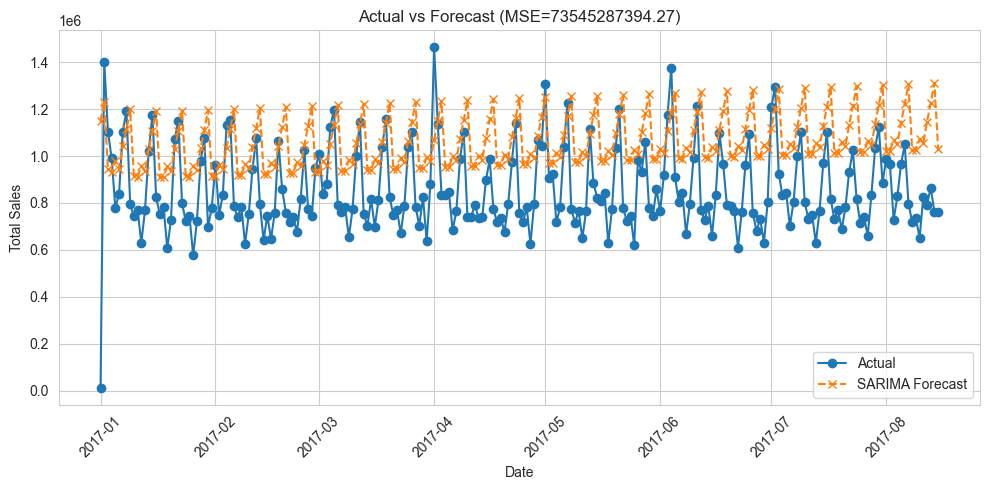

In [23]:
dates = train_test_subset['date']

# 2) Get your predicted values (you already have this)
preds = pred_sarima  # numpy array or list of length len(dates)

# 3) Plot
plt.figure(figsize=(10,5))

# actuals  
plt.plot(dates, 
         train_test_subset['total_sales'], 
         label='Actual', 
         marker='o', 
         linestyle='-')

# forecast  
plt.plot(dates, 
         preds, 
         label='SARIMA Forecast', 
         marker='x', 
         linestyle='--')

plt.title(f'Actual vs Forecast (MSE={mse:.2f})')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Performing stepwise search to minimize aicc
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AICC=1630.064, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AICC=1583.828, Time=0.01 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AICC=1613.866, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AICC=1747.880, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AICC=1583.024, Time=0.00 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AICC=1583.689, Time=0.01 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AICC=1586.169, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AICC=1577.843, Time=0.00 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AICC=1578.618, Time=0.02 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AICC=1578.405, Time=0.01 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AICC=1581.025, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[12] intercept   : AICC=1580.137, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AICC=1580.127, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AICC=1580.395, Time=0.00 sec
 ARI

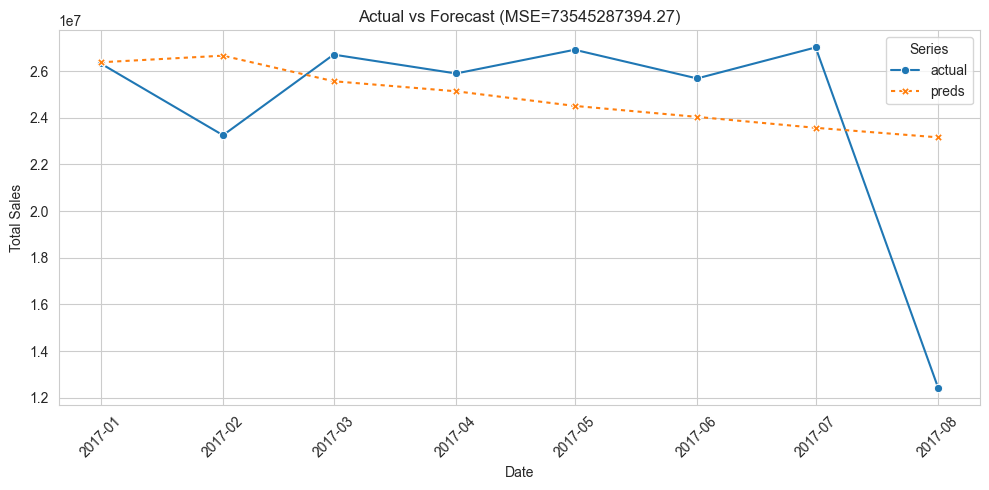

In [39]:
# Try Training on Monthly Data 
mth_top_lvl_df_train = top_lvl_df_train.groupby('year_month').agg(total_sales = ('total_sales', 'sum')).reset_index()

mth_top_lvl_df_train.head(3)

mth_train = mth_top_lvl_df_train[mth_top_lvl_df_train['year_month'].dt.year != 2017]
mth_test = mth_top_lvl_df_train[mth_top_lvl_df_train['year_month'].dt.year == 2017]


sarima_model = auto_arima(
    mth_train['total_sales'],
    seasonal=True,
    m=12,

    # non-seasonal terms
    start_p=0, max_p=5,           # try p=0…5
    start_q=0, max_q=5,           # try q=0…5
    d=None,                       # let it pick d via ADF test
    test='adf',                   # test for unit root

    # seasonal terms
    start_P=0, max_P=2,           # seasonal P up to 2
    start_Q=0, max_Q=2,           # seasonal Q up to 2
    D=None,                       # pick seasonal differences automatically

    # search strategy
    seasonal_test='ocsb',         # seasonal stationarity test
    information_criterion='aicc', # use AICc for small samples
    stepwise=True,                # step-wise backtracking search
    trace=True,                   # log each model it tries

    error_action='ignore',
    suppress_warnings=True
)

mthly_predictions = sarima_model.predict(n_periods=len(mth_test))


dates = mth_test['year_month']

plot_df = pd.DataFrame({
    'date': dates, 
    'actual': mth_test['total_sales'].values,
    'preds': mthly_predictions
})


df_long = plot_df.melt(id_vars='date', 
                      value_vars=['actual','preds'], 
                      var_name='Series', 
                      value_name='Sales')

df_long

plt.figure(figsize=(10,5))

sns.lineplot(
    data = df_long, 
    x = 'date',
    y = 'Sales',
    hue = 'Series',
    style = 'Series',
    markers = True, 
    dashes = {
        'actual': (),       # length‐0 tuple ⇒ solid
        'preds' : (2, 2)    # 2pt on, 2pt off
    }
)

plt.title(f'Actual vs Forecast (MSE={mse:.2f})')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

One-step MSE: 30916975022905.16


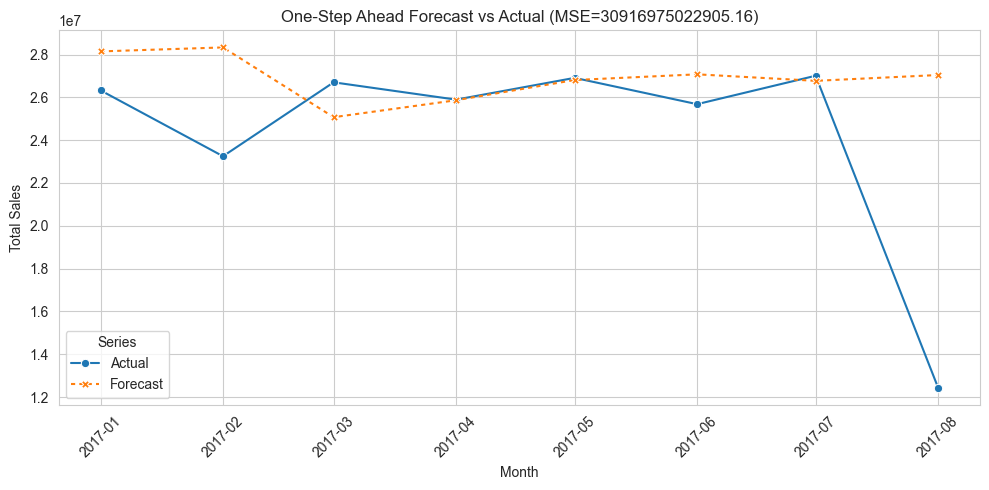

In [ ]:
mth = (
    top_lvl_df_train
    .groupby(top_lvl_df_train['year_month'].dt.to_period('M'))
    ['total_sales']
    .sum()
    .to_timestamp()
)

train = mth[mth.index.year != 2017]
test  = mth[mth.index.year == 2017]


model = auto_arima(
    train,
    seasonal=True, m=12,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None, D=None,
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)


history = train.copy()
preds = []
for actual in test:
    yhat = model.predict(n_periods=1)[0]
    preds.append(yhat)
    model.update(actual)   # incorporate the true value

mse_one_step = mean_squared_error(test, preds)
print(f"One-step MSE: {mse_one_step:.2f}")

df_plot = pd.DataFrame({
    'date':    test.index,
    'Actual':  test.values,
    'Forecast': preds
}).melt('date', var_name='Series', value_name='Sales')

plt.figure(figsize=(10,5))
sns.lineplot(
    data=df_plot,
    x='date',
    y='Sales',
    hue='Series',
    style='Series',
    markers=True,
    dashes={'Actual': '', 'Forecast': (2,2)}
)
plt.title(f'One-Step Ahead Forecast vs Actual (MSE={mse_one_step:.2f})')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()